# Dataset Source

#### [Kaggle Spam detection dataset](https://www.kaggle.com/veleon/ham-and-spam-dataset)

# Import Modules

In [134]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

# Constants

In [174]:
SPAM_PATH = "spam" # folder to extract
HAM_PATH = "ham" # folder to extract

PRACTICE_EXAMPLE = "example.txt"

DATA_JSON_FILE = "email-data.json"

TICK_IMG = "tick.png"
CROSS_IMG = "cross.png"

In [55]:
message = open(PRACTICE_EXAMPLE, encoding='latin-1')
example = message.read()
message.close()

print(type(example))
print(example)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@example.com>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.example.com (listman.example.com [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@example.com>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.example.com (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.example.com
Received: from int-mx1.corp.example.com (int-mx1.corp.example.com
    [172.16.5

In [56]:
message = open(PRACTICE_EXAMPLE, encoding='latin-1')

is_body = False
lines = []

for line in message:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

message.close()

email = '\n'.join(lines)
print(email)


    Date:        Wed, 21 Aug 2002 10:54:46 -0500

    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>

    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>





  | I can't reproduce this error.



For me it is very repeatable... (like every time, without fail).



This is the debug log of the pick happening ...



18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}

18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury

18:19:04 Ftoc_PickMsgs {{1 hit}}

18:19:04 Marking 1 hits

18:19:04 tkerror: syntax error in expression "int ...



Note, if I run the pick command by hand ...



delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury

1 hit



That's where the "1 hit" comes from (obviously).  The version of nmh I'm

using is ...



delta$ pick -version

pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu

# Extract the real content of the emails

In [57]:
def email_content(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [58]:
def build_df(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_content(path):
        rows.append({'EMAIL': email_body, 'LABEL': classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows,index=row_names)
    

In [59]:
spam_emails = build_df(SPAM_PATH,1)
spam_emails.head()

,EMAIL,LABEL
0000.7b1b73cf36cf9dbc3d64e3f2ee2b91f1,,1
0001.bfc8d64d12b325ff385cca8d07b84288,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
0002.24b47bb3ce90708ae29d0aec1da08610,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
0003.4b3d943b8df71af248d12f8b2e7a224a,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
0004.1874ab60c71f0b31b580f313a3f6e777,##############################################...,1


In [60]:
ham_emails = build_df(HAM_PATH,0)
ham_emails.head()

,EMAIL,LABEL
0001.ea7e79d3153e7469e7a9c3e0af6a357e,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
0002.b3120c4bcbf3101e661161ee7efcb8bf,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
0003.acfc5ad94bbd27118a0d8685d18c89dd,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
0004.e8d5727378ddde5c3be181df593f1712,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
0005.8c3b9e9c0f3f183ddaf7592a11b99957,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [61]:
final_df = pd.concat([ham_emails,spam_emails])

In [62]:
final_df.head()

,EMAIL,LABEL
0001.ea7e79d3153e7469e7a9c3e0af6a357e,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
0002.b3120c4bcbf3101e661161ee7efcb8bf,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
0003.acfc5ad94bbd27118a0d8685d18c89dd,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
0004.e8d5727378ddde5c3be181df593f1712,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
0005.8c3b9e9c0f3f183ddaf7592a11b99957,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [63]:
final_df.tail()

,EMAIL,LABEL
0496.e995facc5d5bc6d3f3a8537d35e0432a,There is NO stumbling on to it! \n\n\n\nThe gr...,1
0497.9307bd1fb5347f9fbf1f54ebe95b1d20,This is a multi-part message in MIME format.\n...,1
0498.863566df8e5f17f979edca79d1e87187,"<html>\n\n\n\n<head>\n\n<meta http-equiv=""Cont...",1
0499.4a17fbd7fe71705e09b4dd2e24d802dd,"<HTML>\n\n<BODY>\n\n <tr valign=3D""top""> \n\n...",1
0500.2e8762b67913d1b07bc8da293448d27f,UNCOMMON EXOTIC PLEASURE BOTANICALS!\n\n\n\nFe...,1


# Missing data

<AxesSubplot:>

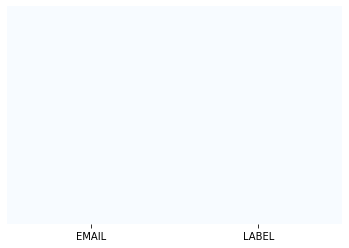

In [64]:
sns.heatmap(final_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [65]:
(final_df.EMAIL.str.len()==0).sum()

1

In [82]:
i = final_df[final_df.EMAIL.str.len()==0].index

In [83]:
final_df.drop(i,inplace=True)

In [84]:
doc_ids = range(0,len(final_df))
final_df['DOC_ID'] = doc_ids

In [85]:
final_df['FILE_NAME'] = final_df.index
final_df.set_index('DOC_ID',inplace=True)

In [175]:
final_df.to_json(DATA_JSON_FILE) # in case to restart the model and not doing all this again

# Percentage of spam 

In [86]:
count_emails=final_df['LABEL'].value_counts()
count_emails

0    2551
1     500
Name: LABEL, dtype: int64

In [87]:
ham = count_emails.values[0]
spam = count_emails.values[1]

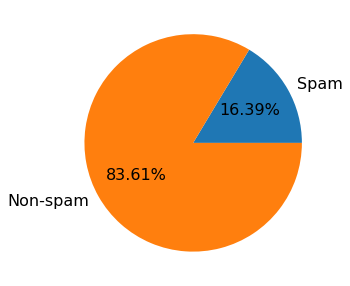

In [88]:
label = ['Spam','Non-spam']
plt.figure(figsize=(5,5))
emails = [spam,ham]
plt.pie(emails, labels=label, textprops= {'fontsize': 16},autopct='%1.2f%%')
plt.show()

# NLP

## Remove stop words, stemming words and clean html

In [89]:
def clean_message_no_html(message, stemmer = PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    # Remove HTLM
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    # Converts to Lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words= []
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [90]:
list_docs = final_df.EMAIL.apply(clean_message_no_html)

F:\Ana3\envs\tensorflow_env\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp






" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [91]:
list_docs

DOC_ID
0       [date, wed, aug, chri, garrigu, ca, reproduc, ...
1       [martin, post, tasso, papadopoulo, greek, scul...
2       [man, threaten, explos, moscow, thursday, augu...
3       [klez, viru, wo, die, alreadi, prolif, viru, e...
4       [wed, aug, ulis, ponc, wrote, hi, command, ins...
                              ...                        
3046    [stumbl, greatest, way, market, centuri, undou...
3047    [messag, mime, format, mean, made, usa, cna, h...
3048    [unlist, inform, messag, brought, complianc, c...
3049    [ebay, rate, work, home, busi, opportun, pc, m...
3050    [uncommon, exot, pleasur, botan, feel, marvel,...
Name: EMAIL, Length: 3051, dtype: object

## Create the wordCloud 

#### Subseting the dataframes into spam and non-spam

In [97]:
list_docs_ham = final_df[final_df.LABEL==0].index

In [98]:
list_docs_spam = final_df[final_df.LABEL==1].index

In [99]:
list_ham = list_docs.loc[list_docs_ham]

In [101]:
list_spam = list_docs.loc[list_docs_spam]

In [102]:
flat_list_ham = [item for sublist in list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

15370

In [103]:
normal_words.head(10)

http      4426
use       2177
list      1442
get       1413
one       1342
mail      1309
like      1196
would     1185
messag    1127
time      1093
dtype: int64

In [107]:
flat_list_spam = [item for sublist in list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

spam_words.shape[0]

7046

In [108]:
spam_words.head(10)

free      658
email     643
http      638
receiv    561
money     498
list      488
get       475
pleas     474
order     443
name      436
dtype: int64

In [118]:
def get_mask(image, words,colormap):
    icon = Image.open(image)
    image_mask = Image.new(mode='RGB',size=icon.size, color=(255,255,255))
    image_mask.paste(icon, box=icon)
    rgb_array = np.array(image_mask) # converts the image object to an array

    ham_str= ' '.join(flat_list_ham)

    word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_font_size=300,
                          max_words=words, colormap=colormap)
    word_cloud.generate(ham_str)
    plt.figure(figsize=(16,8))
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.axis('off')
    return plt.show()

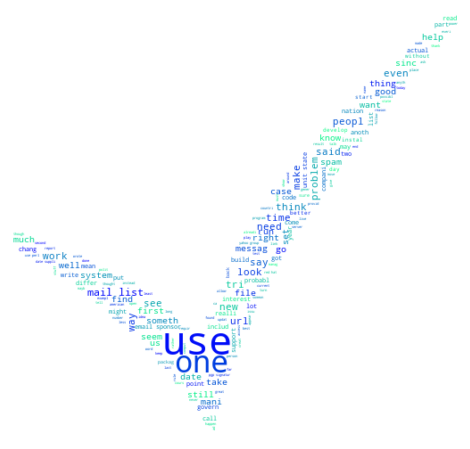

In [121]:
get_mask(TICK_IMG,1000,'winter')

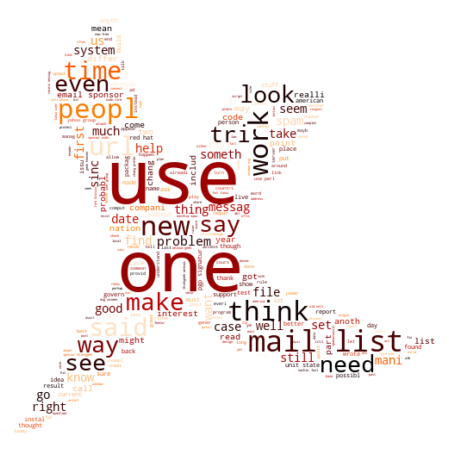

In [122]:
get_mask(CROSS_IMG,1000,'gist_heat')